#### **PROGRAMA QUE UTILIZA MACHING LEARNIN PARA CLASIFICAR LOS MANGOS MADUROS Y PODRIDOS**
---


Este programa ilustra el uso de las librerías skimage, pathlib, numpy y matplotlib, para cargar un dataset de imagenes, inspeccionar datos, graficar y corregir errores. El conjunto de datos tomado para este trabajo es de: https://www.kaggle.com/datasets/adrinbd/unripe-ripe-rotten-mango

Este conjunto de datos cuenta con una clasificacion de 3 estados del mango, maduro(ripe), inmaduro(unripe) y podrido(rotten) con sus respectivas imagenes para el entrenamiento del modelo, de este conjunto de datos solo se tendran en cuenta los estados maduros y podridos, se trabajara con las mascaras de los mangos, el proceso para obtener estas mascaras no se tendra en cuneta en este trabajo.

El objetivo de estos conjuntos de imagenes es ser capas de difinir si un mango esta maduro(ripe) o podrido(rotten), usando ese conjunto de imagenes para entrenar este modelo.

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import os

from skimage.data import page
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

import pandas as pd
import numpy as np
import skimage as ski
import statistics


from scipy.ndimage import binary_fill_holes
from sklearn.preprocessing import MinMaxScaler
from skimage.morphology import remove_small_objects




Se creara la función **obtener_imagenes()**, la cual retornara una lista donde cada elemento de la lista contendra un vector de cuatro posiciones con el nombre de la imagen, la imagen a color, la imagen en escala de grises y dejara una posicion disponible para la mascara de cada imagen, dichas mascaras estan en otra carpeta y se agregaran por medio de otra funcion.

In [2]:
def obtener_imagenes(ruta_carpeta):
    """Devuelve una lista de imágenes normales y en escala de grises de la carpeta especificada con el respectivo nombre de la imgen."""
    imagenes = []
    cont = 0
    for archivo in os.listdir(ruta_carpeta):
        try:
            img = ski.io.imread(ruta_carpeta+"/"+archivo)
            img = ski.util.img_as_ubyte(img)
            gray_image = rgb2gray(img)
            imagenes.append([archivo,img,gray_image, ""])
        except Exception as e:
            cont = cont + 1

    return imagenes

La funcion **obtener_mask()**, recibe como parametro la ruta en la que se encuentran las mascaras y la lista que contiene las imagenes con sus nombres, imagen, imagen en escala de grises y el espacion donde se almacenara la mascara correspondiente, cabe aclarar que las mascaras tienen el mismo nombre que la imagen original agregando mark_ripe o mark_rotten, estos separado por un guion bajo, al final retornara la lista que recibe con el espacio de la mascara lleno con su mascara correspondiente.

In [3]:
def obtener_mask(ruta_carpeta, coleccion):
    imagenes = []
    cont = 0
    carpeta = os.listdir(ruta_carpeta)
    for i in coleccion:
        nombre_img = obtener_primera_palabra(i[0],".")
       
        for archivo in carpeta:

            nombre_mask = obtener_primera_palabra(archivo,"_")
            #print(nombre_mask, "y",nombre_img)
                     
            if nombre_img == nombre_mask:
                mask = np.load(ruta_carpeta+"/"+archivo) 
                if len(mask.shape) == 3:
                    mask=mask[:,:,1]
                if mask.shape == i[2].shape:
                    i[3] = mask
                    imagenes.append(i)
                break


    return imagenes

La funcion **obtener_primera_palabra()**,  permite obtener la palabra de una cadena que aparece antes del caracter que recibe por parametro.

In [4]:
def obtener_primera_palabra(palabra, caracter):
    p = palabra.split(caracter)
    return p[0]

La funcion **intensity_table()**, crea una tabla con el valor de la intensidad de la imagen en escala de grises

In [5]:
def intensity_table(grayValues):
    table = {}
    for ival in range(256):
        table['val_'+ str(ival)] = [np.count_nonzero(grayValues == ival)]

    df_table = pd.DataFrame.from_dict(table, orient='columns')
    return df_table

In [6]:
def hist2features(grayImg, mangoMask):
    
    gray = ski.util.img_as_ubyte(grayImg)
    mango_mask = mangoMask
    
    masked_gray = gray * mango_mask
    
    plt.imshow(gray, cmap = 'gray')
    plt.show()
    plt.imshow(masked_gray, cmap = 'gray')
    plt.show()
    df_intensities = intensity_table(masked_gray)
    #print(df_intensities)
    return df_intensities

obtenemos las imagenes para los mango ripe y para los mangos rotten.

In [7]:
ripe = obtener_imagenes("./ripe")
rotten = obtener_imagenes("./rotten")


obtenemos la mascara respectiva de cada imagen almacenada en las listas ripe y rotten

In [8]:
ripe = obtener_mask("./ripe_masks",ripe)
rotten = obtener_mask("./rotten_masks",rotten)

visulaizamos las imagen en escala de grises y como se veria en escala de grises con su mascara.

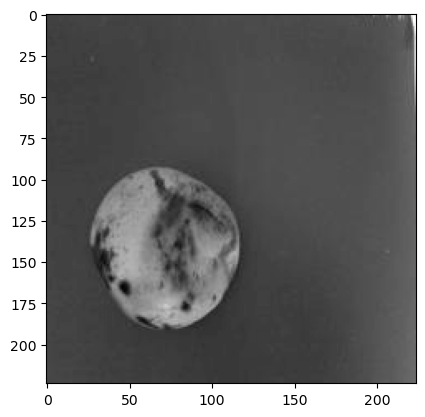

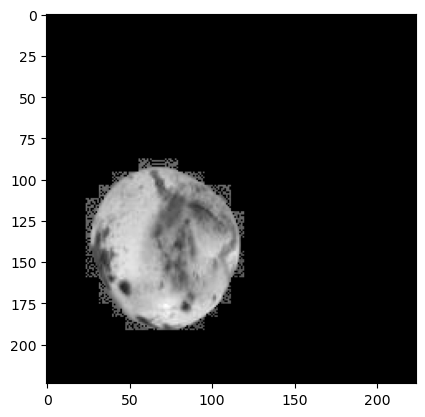

,val_0,val_1,val_2,val_3,val_4,val_5,val_6,val_7,val_8,val_9,...,val_246,val_247,val_248,val_249,val_250,val_251,val_252,val_253,val_254,val_255
0,42602,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
i =100
imagen_prueba = rotten[i]
hist2features(imagen_prueba[2],imagen_prueba[3])

creamos la **funcion extract_properties()**, para extraer la variables de prediccion que se usaran para el modelo de clasificacion y almacenarlas en un dataframe.

In [10]:
def extract_properties(gray_img, mango_mask):

    labeled_mango, count = ski.measure.label(mango_mask, connectivity=2, return_num=True)
    
    object_features = ski.measure.regionprops(labeled_mango)

    var_gris_props = ['area', 'intensity_max', 'intensity_min', 'intensity_mean']
    gris_props = ski.measure.regionprops_table(labeled_mango, gray_img, properties=var_gris_props)
    
    grayImg_stdev = std_image(gray_img, mango_mask)
    df_image = pd.DataFrame(gris_props)
    
    df_image.rename(columns={'intensity_max': 'max_gray_value', 'intensity_min': 'min_gray_value', 'intensity_mean': 'mean_gray_value'}, inplace=True)
    df_image['std'] = grayImg_stdev 
        
    return df_image

Entre las varibles de prediccion a usar esta la varianza por lo tanto es necesario calcularla por aparte, e incluirla en el dataframe.

In [11]:
def std_image(gray_img, mango_mask):
    mango_mask = ski.util.invert(mango_mask)
    idx_list = np.where(mango_mask == 1)
    mangoPixel_values = gray_img[idx_list]
    stdev = statistics.stdev(mangoPixel_values)
    return stdev

Se implementara una prueba en una imagen, para verificar las variables que se extraen de la imagen, se estara utilizando la imagen que se visualizo anteriormente, las variables a extraer seran:
* area
* max_gray_value
* min_gray_value
* mean_gray_value
* std

In [12]:
df_ejemplo=extract_properties(imagen_prueba[2],imagen_prueba[3])
print(df_ejemplo)

     area  max_gray_value  min_gray_value  mean_gray_value       std
0  7572.0        0.813182        0.102485         0.495497  0.040982
1     1.0        0.305664        0.305664         0.305664  0.040982
2     1.0        0.320669        0.320669         0.320669  0.040982


como se puede ver en la tabla de el dataframe anterior, la funcion **extract_properties()** esta obteniendo las caracteristicas que necesitamos pero, tiene mas de una entrada, viendo la caracteristica "area" se puede encontrar que hay un area con muchos pixeles mientras que las demas areas son pequeñas, esto nos indica que la mascara esta generando ruido, teniendo en cuenta que el area a analizar es el area donde se encuentra el mango, y el mango representa una gran numero de pixeles, se puede concluir que el area con la mayor cantidad de pixeles es el area en la que se encuentra el mango, razon por la cual hay que descartar las demas areas y quedarnos solo con la mas grande.

La funcion **obtener_area_mas_grande()** permitira hacer lo mencionado antenriormente, obtendra el index del area max grande, y con el eliminaremos todas las demas areas menos la ubicada en el index obtenido. y retornara el dataframe solo con las caracteristicas correspodientes a esa area.

In [13]:
def obtener_area_mas_grande(df):
    index = df['area'].idxmax()
    area_mas_grande = df.iloc[[index]]
    return area_mas_grande

para mostrar el uso de esta funcion seguiremos usando el ejemplo anterior:

In [14]:
print(obtener_area_mas_grande(df_ejemplo))

     area  max_gray_value  min_gray_value  mean_gray_value       std
0  7572.0        0.813182        0.102485         0.495497  0.040982


como se puede observar, la funcion **obtener_area_mas_grande()** cumple su proposito, ahora sera necesario hacer esto mismo para todas las imagenes y almacenarlo en un dataframe, para esto se usara la funcion **obtener_data_frame_imagenes()**, la cual recibira la lista de imagenes que se crea de los respectivos tipos de mangos y a partir de ella crea un dataframe de cada imagen de mango solo con las caracteristicas seleccionadas.

In [15]:
def obtener_data_frame_imagenes(lista_imagenes):
    df = extract_properties(lista_imagenes[0][2],lista_imagenes[0][3])
    df = obtener_area_mas_grande(df)
    
    for imagen in lista_imagenes[1:]:
        df_ciclo = extract_properties(imagen[2],imagen[3])
        df_ciclo = obtener_area_mas_grande(df_ciclo)
        df =  pd.concat([df, df_ciclo], ignore_index=True)
        
        
    return df

A continuacion se extraera el dataframe de los mangos ripe.

In [16]:
df_ripe = obtener_data_frame_imagenes(ripe)

In [17]:
print(df_ripe)

        area  max_gray_value  min_gray_value  mean_gray_value       std
0     4560.0        0.657422        0.096415         0.445445  0.109363
1     4082.0        0.675431        0.072455         0.408536  0.059956
2     8716.0        0.671715        0.106655         0.475659  0.051618
3     7399.0        0.615909        0.064277         0.363080  0.029167
4     4539.0        0.593028        0.060416         0.363767  0.034493
..       ...             ...             ...              ...       ...
289  13767.0        0.764513        0.105748         0.396082  0.116050
290   8045.0        0.602485        0.067388         0.387897  0.031983
291   9706.0        0.652587        0.073274         0.377345  0.039939
292  11870.0        0.728333        0.088693         0.398226  0.068697
293  13666.0        0.682874        0.039722         0.419652  0.043466

[294 rows x 5 columns]


A continuacion se extraera el dataframe de los mangos rotten.

In [18]:
df_rotten = obtener_data_frame_imagenes(rotten)

In [19]:
print(df_rotten)

        area  max_gray_value  min_gray_value  mean_gray_value       std
0    38239.0        0.895004        0.009167         0.434802  0.154488
1    26817.0        1.000000        0.007843         0.559756  0.032708
2    35125.0        0.788041        0.020611         0.582307  0.092272
3    37395.0        0.952043        0.000565         0.688276  0.098557
4    37697.0        0.978420        0.103941         0.400430  0.104594
..       ...             ...             ...              ...       ...
535  30213.0        1.000000        0.006667         0.372301  0.088876
536  37362.0        0.941258        0.004167         0.553169  0.279407
537  31724.0        0.897565        0.005833         0.411765  0.159261
538  32777.0        1.000000        0.024167         0.517712  0.037552
539  17131.0        1.000000        0.010878         0.458615  0.022709

[540 rows x 5 columns]


Para poder entrenar el modelo sera necesario tener el dataframe de mangos ripe y el dataframe de mangos rotten en uno solo, pero para ello sera necesaria una nueva caracteristica para identificar un mango ripe de un mango rotten, por lo tanto se creara la caracteristica **clase** con valores de **0** para **rotten** y **1** para **ripe**.

In [20]:
df_mangos_combinado = pd.concat([df_ripe, df_rotten], ignore_index=True)
# Creamos una nueva columna 'clase' y asignamos los valores
df_mangos_combinado['clase'] = 1
df_mangos_combinado.loc[df_mangos_combinado.index >= len(df_ripe), 'clase'] = 0
print(df_mangos_combinado)

        area  max_gray_value  min_gray_value  mean_gray_value       std  clase
0     4560.0        0.657422        0.096415         0.445445  0.109363      1
1     4082.0        0.675431        0.072455         0.408536  0.059956      1
2     8716.0        0.671715        0.106655         0.475659  0.051618      1
3     7399.0        0.615909        0.064277         0.363080  0.029167      1
4     4539.0        0.593028        0.060416         0.363767  0.034493      1
..       ...             ...             ...              ...       ...    ...
829  30213.0        1.000000        0.006667         0.372301  0.088876      0
830  37362.0        0.941258        0.004167         0.553169  0.279407      0
831  31724.0        0.897565        0.005833         0.411765  0.159261      0
832  32777.0        1.000000        0.024167         0.517712  0.037552      0
833  17131.0        1.000000        0.010878         0.458615  0.022709      0

[834 rows x 6 columns]


con los dataframe ya unidos, podemos ver aparntemente que todas las caracteristicas estan normalizadas con valores entre 0 y 1 a excepcio del area la cual sera normalizada para mejorar la efectividad del modelo. para verificar utilizamos la funcion **describe()**.

In [21]:
print(df_mangos_combinado.describe())

                area  max_gray_value  min_gray_value  mean_gray_value  \
count     834.000000      834.000000      834.000000       834.000000   
mean    18134.386091        0.788308        0.089048         0.463554   
std     50663.334097        0.131701        0.060429         0.137062   
min      2753.000000        0.534254        0.000000         0.187331   
25%      5979.500000        0.669839        0.041029         0.323070   
50%      8044.500000        0.785519        0.083270         0.481942   
75%     11631.000000        0.896114        0.131340         0.577785   
max    665337.000000        1.000000        0.296609         0.818165   

              std       clase  
count  834.000000  834.000000  
mean     0.099770    0.352518  
std      0.073221    0.478041  
min      0.012606    0.000000  
25%      0.040531    0.000000  
50%      0.070867    0.000000  
75%      0.143975    1.000000  
max      0.336310    1.000000  


Con esto se puede confirmar que todos los valores se encuentran entre 0 y 1 a excepcion de el area la cual sera necesario normalizar.

Para confirmar que la normalizacion se halla realizado corectamente, verificaremos con la funcion **describe()**.

In [22]:
print(df_mangos_combinado.describe())

                area  max_gray_value  min_gray_value  mean_gray_value  \
count     834.000000      834.000000      834.000000       834.000000   
mean    18134.386091        0.788308        0.089048         0.463554   
std     50663.334097        0.131701        0.060429         0.137062   
min      2753.000000        0.534254        0.000000         0.187331   
25%      5979.500000        0.669839        0.041029         0.323070   
50%      8044.500000        0.785519        0.083270         0.481942   
75%     11631.000000        0.896114        0.131340         0.577785   
max    665337.000000        1.000000        0.296609         0.818165   

              std       clase  
count  834.000000  834.000000  
mean     0.099770    0.352518  
std      0.073221    0.478041  
min      0.012606    0.000000  
25%      0.040531    0.000000  
50%      0.070867    0.000000  
75%      0.143975    1.000000  
max      0.336310    1.000000  


como se puede ver, todos los valores ahora se encuentran normalizados entre cero y uno, a continuacion un histograma para verificar con cuantos datos contamos de los mangos ripe y rotten.

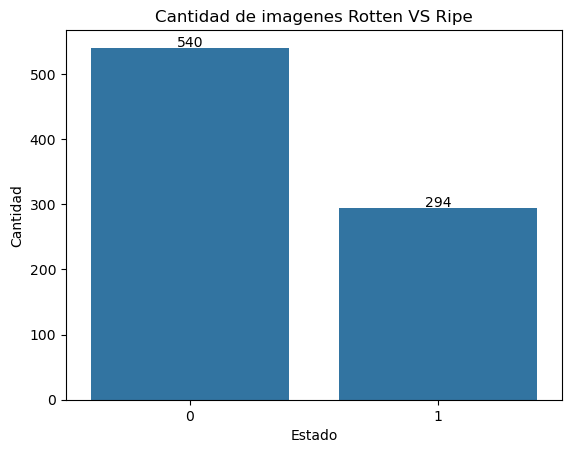

In [23]:
count_ripe = df_mangos_combinado['clase'].value_counts()[1]
count_rotten = df_mangos_combinado['clase'].value_counts()[0]

sns.countplot(x='clase', data=df_mangos_combinado)

plt.text(0,count_rotten +2, str(count_rotten), ha='center')
plt.text(1,count_ripe +2, str(count_ripe), ha='center')

# Personalizar el gráfico
plt.title('Cantidad de imagenes Rotten VS Ripe')
plt.ylabel('Cantidad')
plt.xlabel('Estado')
plt.show()

Como se ve en la grafica de istogramas anterior, la cantidad de imagenes de las clases, se encuentra desbalanceada a favor de los mangos rotten, teniendo este casi el doble de imagenes de los mangos ripe; pero ambas clases contienen ejemplos. Inspeccionemos también los histogramas de frecuencia para las variables predictoras de este ejemplo, las cuales también son todas de tipo numérico

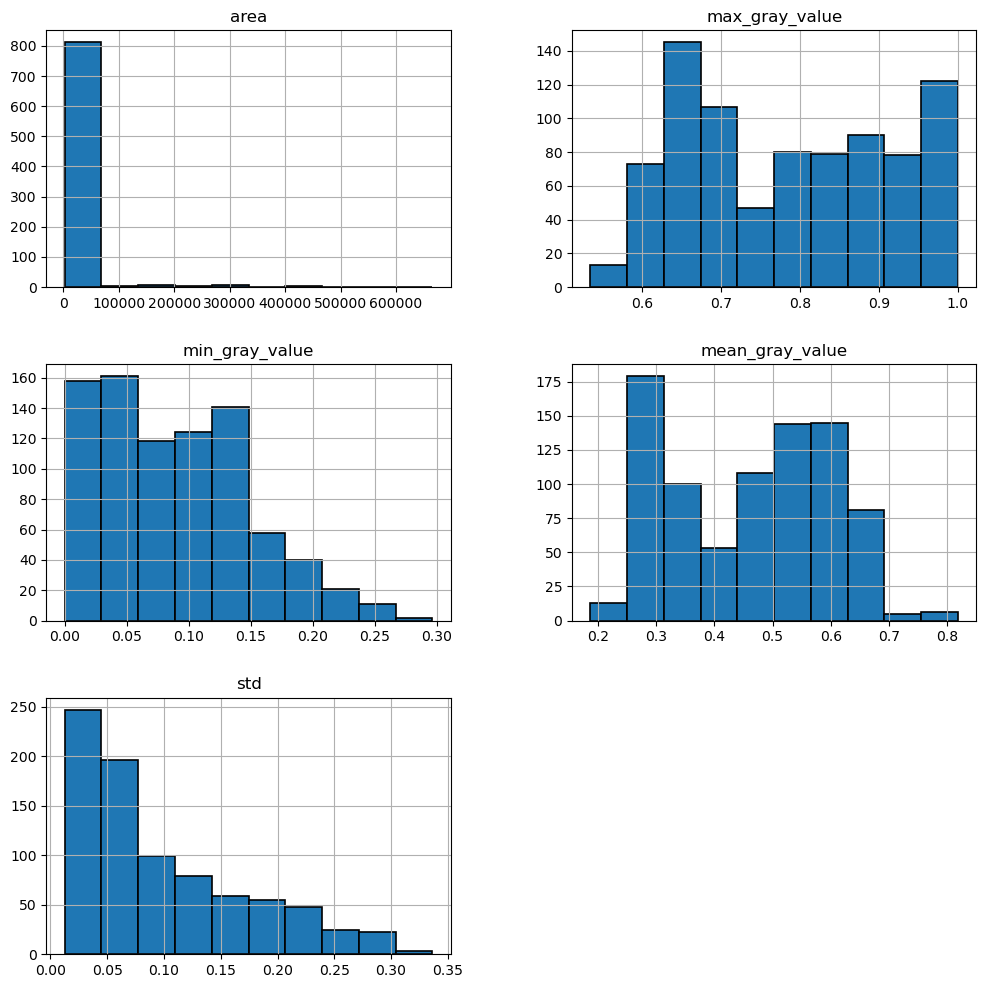

In [24]:
mangos_var = df_mangos_combinado.drop(['clase'], axis=1)
mangos_var.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [38]:
x = 19000

# Filtrar el DataFrame y crear uno nuevo
df_filtrado = df_mangos_combinado[df_mangos_combinado['area'] < x]

print(df_filtrado)

        area  max_gray_value  min_gray_value  mean_gray_value       std  clase
0     4560.0        0.657422        0.096415         0.445445  0.109363      1
1     4082.0        0.675431        0.072455         0.408536  0.059956      1
2     8716.0        0.671715        0.106655         0.475659  0.051618      1
3     7399.0        0.615909        0.064277         0.363080  0.029167      1
4     4539.0        0.593028        0.060416         0.363767  0.034493      1
..       ...             ...             ...              ...       ...    ...
791  10062.0        0.965505        0.151250         0.598094  0.024825      0
792  11755.0        0.939169        0.163274         0.611556  0.051405      0
793   7607.0        0.892757        0.198025         0.597324  0.076289      0
794  11953.0        0.833471        0.113304         0.561568  0.031937      0
833  17131.0        1.000000        0.010878         0.458615  0.022709      0

[716 rows x 6 columns]


In [39]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el scaler a los datos y transformarlos
df_normalized = scaler.fit_transform(df_filtrado)

# Convertir el resultado a un DataFrame
df_filtrado = pd.DataFrame(df_normalized, columns=df_filtrado.columns)
print(df_filtrado)

         area  max_gray_value  min_gray_value  mean_gray_value       std  \
0    0.112938        0.264453        0.343799         0.365877  0.303156   
1    0.083062        0.303120        0.258364         0.301770  0.147434   
2    0.372687        0.295141        0.380316         0.418355  0.121154   
3    0.290375        0.175322        0.229201         0.222818  0.050391   
4    0.111625        0.126193        0.215433         0.224010  0.067178   
..        ...             ...             ...              ...       ...   
711  0.456812        0.925936        0.539333         0.631013  0.036708   
712  0.562625        0.869389        0.582209         0.654396  0.120483   
713  0.303375        0.769740        0.706127         0.629676  0.198912   
714  0.575000        0.642448        0.404026         0.567571  0.059122   
715  0.898625        1.000000        0.038789         0.388752  0.030039   

     clase  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      1.0  
..     ..

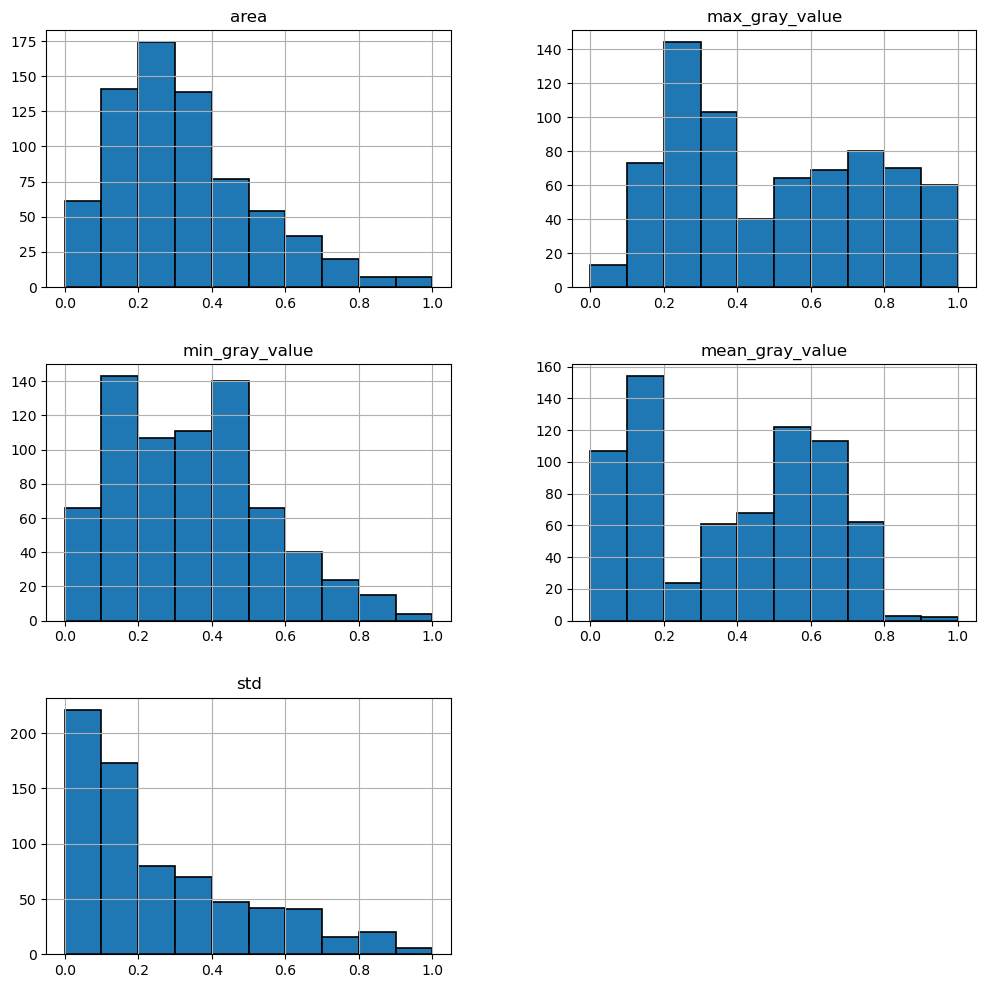

In [40]:
mangos_var2 = df_filtrado.drop(['clase'], axis=1)
mangos_var2.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

<Axes: >

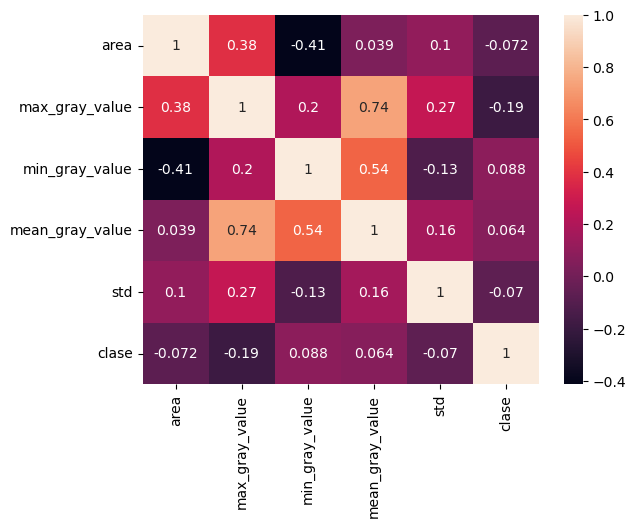

In [37]:

# Crear el mapa de calor
sns.heatmap(df_filtrado.corr(), annot=True)